## Subproblem selection for CrossCat with the Metamodeling Language

### Inference plans in MML

#### Specifying deterministic constraints

```
ALTER ANALYSIS SCHEMA <s> [ANALYSES (<indexes>)]

    ENSURE <variables..> DEPENDENT
    ENSURE <variables...> INDEPENDENT
    ENSURE <variables...> IN CONTEXT OF <variable>
    ENSURE <variables...> IN SINGLETON CONTEXT
    
    ENSURE ROWS <rows...> IN CLUSTER OF <row> WITHIN CONTEXT OF <variable>
    ENSURE ROWS <rows...> IN SINGLETON CLUSTER WITHIN CONTEXT OF <variable>    
    
    SET CONTEXT CONCENTRATION PARAMETER TO <value>
    SET ROW CLUSTERING CONCENTRATION WITHIN CONTEXT OF <variable> TO <value>
    
```

#### Stochastic mutation via Gibbs sampling

```
ANALYZE <s> [ANALYSES (<indexes>)] FOR <n> ITERATIONS|SECONDS WAIT (

    VARIABLES <variables...>
    ROWS <rows...>

    SUBPROBLEMS (
        VARIABLE HYPERPARAMETERS,
        VARIABLE CLUSTERING,
        VARIABLE CLUSTERING CONCENTRATION,
        ROW CLUSTERING,
        ROW CLUSTERING CONCENTRATION,
    )
    
    [OPTIMIZED];
)
```

The tokens `<variables...>` and `<rows...>` are either variable/row names, or `*` to indicate all.

Combinations of the above `ALTER` and `SUBPROBLEMS` are sufficient to recover several models that CrossCat generalizes, such as single/multi-row cluster models as well as fully-dependent and fully-independent variables.


### Outline of notebook

1. Load bivariate, bimodal synthetic dataset into bql table.
2. Create a population.
3. Create an analysis schema, assuming full independence (naive Bayes), from the prior.
4. Compare selections and simulations; poor match, and simulations are highly overdispersed.
5. Run inference on `VARIABLE HYPERPARAMETERS` subproblem; simulations still poor match but demonstrate correct variance.
6. Run inference on `VARIABLE HYPERPARAMETERS, ROW CLUSTERING` subproblems; marginal simulations match, but joint simulations do not match.
7. Run inference on `VARIABLE CLUSTERING` subproblem; marginal and joint simulations match correctly.
8. Create a CrossCat state with default inference plan on all subproblems; same outcome as manually running steps 1-7.

In [1]:
%load_ext iventure.magics
%matplotlib inline

session_id: fsaad@probcomp-1.csail.mit.edu_2017-07-26T11:07:39.042276_8


In [2]:
%bayesdb :memory:

u'Loaded: :memory:'

#### Load the data and scatter.

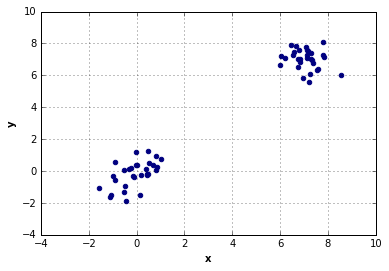

In [3]:
%bql CREATE TABLE t FROM 'resources/synthetic.csv'
%bql .scatter SELECT * FROM t;

#### Create a population.

In [4]:
%mml CREATE POPULATION p FOR t WITH SCHEMA (MODEL x, y AS NUMERICAL);

""


#### Create an analysis schema with the CrossCat baseline, forced to full independence (Naive Bayes).

In [5]:
%mml CREATE ANALYSIS SCHEMA s FOR p WITH BASELINE crosscat;
%mml INITIALIZE 1 ANALYSIS FOR s;
%mml ALTER ANALYSIS SCHEMA s ENSURE VARIABLES * INDEPENDENT;

""


#### Render random initial state.

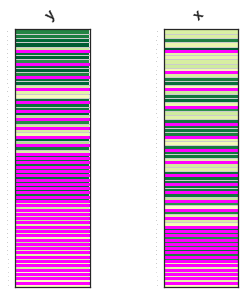

In [6]:
%mml .render_crosscat --height=5 --width=4 s 0

#### Compare the marginal histogram with simulations of X. They do not match, and simulations of X are overdispersed.

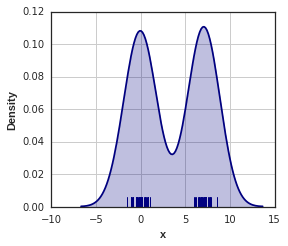

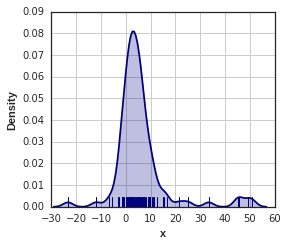

In [7]:
%bql .density SELECT x FROM t
%bql .density SIMULATE x FROM p LIMIT 100

#### Compare the marginal histogram with simulations of Y. They do not match, and simulations of Y are overdispersed.

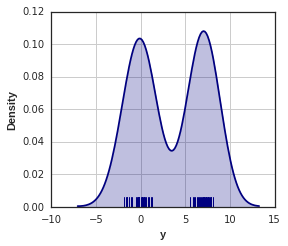

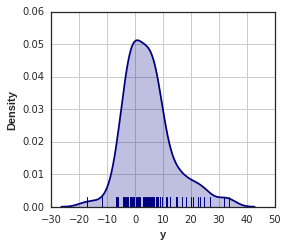

In [8]:
%bql .density SELECT y FROM t
%bql .density SIMULATE y FROM p LIMIT 100

#### Compare joint histograms with simulations of X, Y. They do not match, and variance of simulated data is very high.

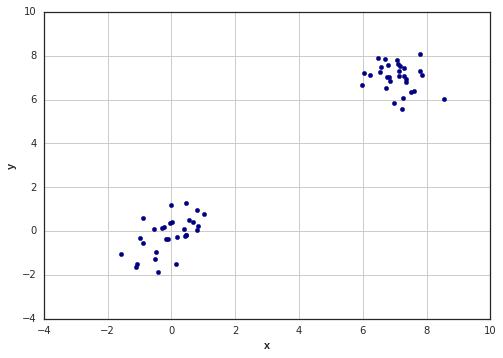

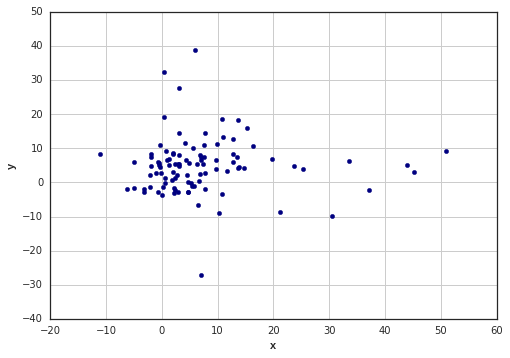

In [9]:
%bql .scatter SELECT x, y FROM t
%bql .scatter SIMULATE x, y FROM p LIMIT 100;

#### Let us run hyperparameter inference only to reduce the overdispersion in the simulations.

In [10]:
%%mml
ANALYZE s FOR 50 ITERATIONS WAIT (

    VARIABLES x, y;
    
    SUBPROBLEMS (
        VARIABLE HYPERPARAMETERS
))

Completed: 50 iterations in 17.666451 seconds.


""


#### Comparing the joint historgrams to posterior simulations.

Lack of fit is still clear, but the variance of the simulations is much more in line with the actual data.

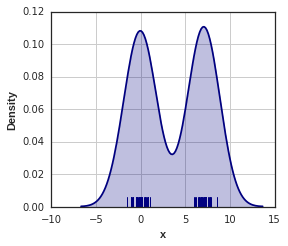

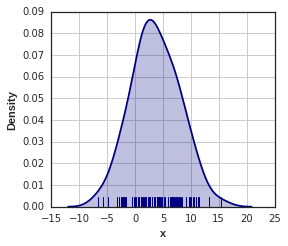

In [11]:
%bql .density SELECT x FROM t
%bql .density SIMULATE x FROM p LIMIT 100

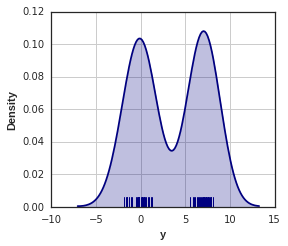

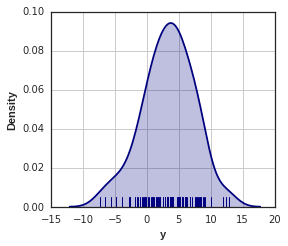

In [12]:
%bql .density SELECT y FROM t
%bql .density SIMULATE y FROM p LIMIT 100

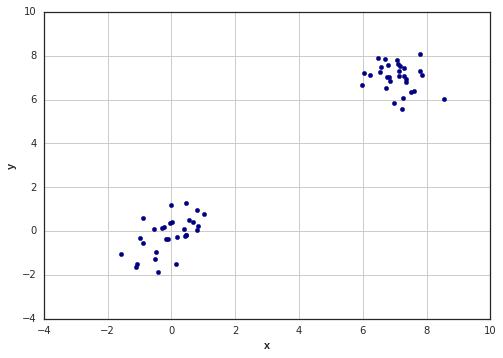

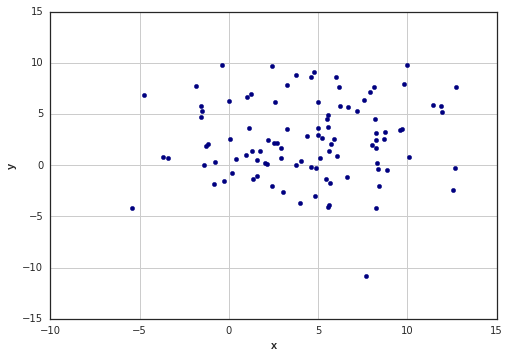

In [13]:
%bql .scatter SELECT x, y FROM t
%bql .scatter SIMULATE x, y FROM p LIMIT 100;

#### Now let us run analysis on the variable hyperparameters, and row clusterings and concentration of X and Y

In [14]:
%%mml
ANALYZE s FOR 100 ITERATIONS WAIT (

    VARIABLES x, y;
    
    SUBPROBLEMS (
        VARIABLE HYPERPARAMETERS,
        ROW CLUSTERING,
        ROW CLUSTERING CONCENTRATION
))

Completed: 100 iterations in 21.026773 seconds.


""


#### Compare the marginal histograms with simulations of X. They match now.

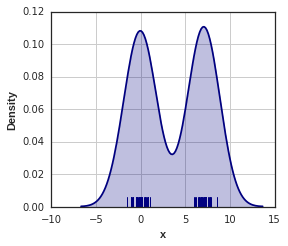

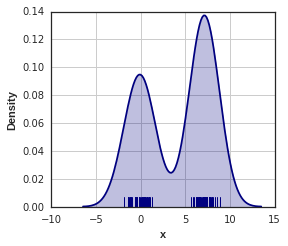

In [15]:
%bql .density SELECT x FROM t
%bql .density SIMULATE x FROM p LIMIT 100

#### Compare the marginal histograms with simulations of Y. They match now.

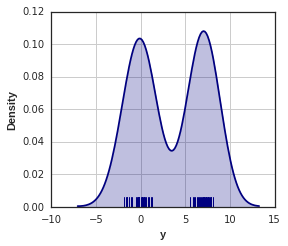

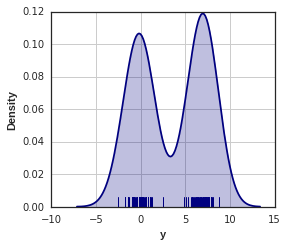

In [16]:
%bql .density SELECT y FROM t
%bql .density SIMULATE y FROM p LIMIT 100

#### Compare the joint histogram with simulations of X and Y. They still do not match.

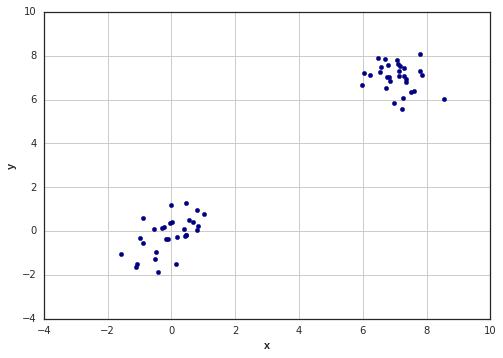

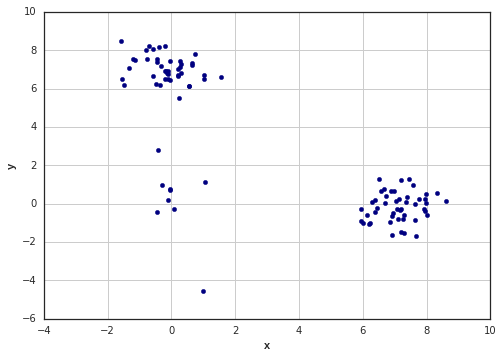

In [17]:
%bql .scatter SELECT x, y FROM t
%bql .scatter SIMULATE x, y FROM p LIMIT 100;

#### Render the CrossCat state to view the row clustering in each context. There appears some redundacy in the modality.

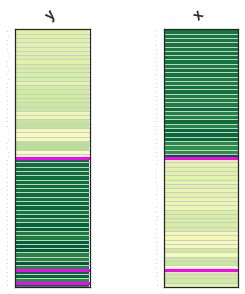

In [18]:
%mml .render_crosscat --height=5 --width=4 s 0

#### Run inference on the row clustering to clear out weak modes.

In [19]:
%%mml
ANALYZE s FOR 150 ITERATIONS WAIT (
    SUBPROBLEMS(
        ROW CLUSTERING
))

Completed: 150 iterations in 11.984611 seconds.


""


#### The bi-modality is now clear.

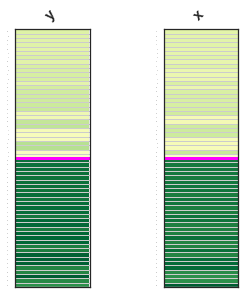

In [20]:
%mml .render_crosscat --height=5 --width=4 s 0

#### Run category inference to capture covariance.

In [21]:
%%mml
ANALYZE s FOR 200 ITERATIONS WAIT (
    SUBPROBLEMS(
        VARIABLE CLUSTERING,
        VARIABLE CLUSTERING CONCENTRATION
))

Completed: 200 iterations in 7.461873 seconds.


""


#### Render the CrossCat state to verify X and Y are jointly modeled.

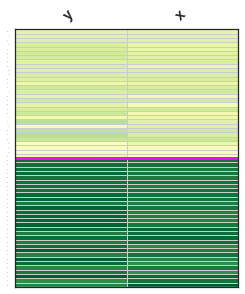

In [22]:
%mml .render_crosscat --height=5 --width=4 s 0

#### Compare the joint histograms to simulations of X, Y. Now they match, as do the marginals.

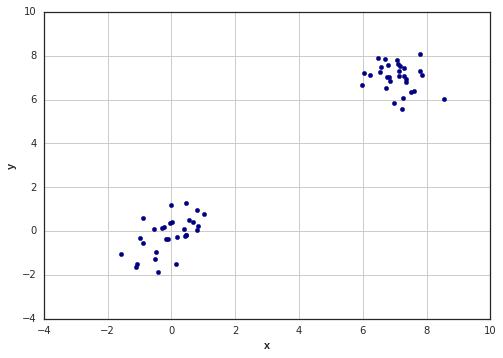

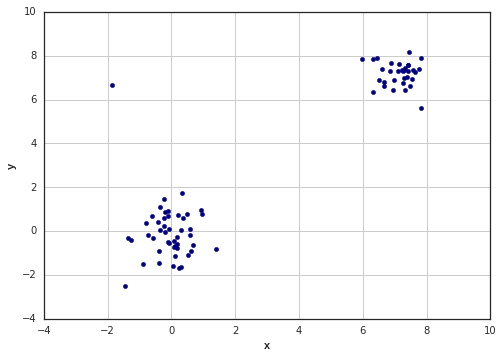

In [23]:
%bql .scatter SELECT x, y FROM t
%bql .scatter SIMULATE x, y FROM p LIMIT 80;

#### Now create an analysis schema with the CrossCat baseline and no independence assumptions.

In [24]:
%mml CREATE ANALYSIS SCHEMA s2 FOR p WITH BASELINE crosscat;
%mml INITIALIZE 1 ANALYSIS FOR s2;

""


#### Render the initial random state.

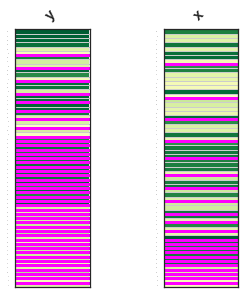

In [25]:
%mml .render_crosscat --height=5 --width=4 s2 0

#### Run analysis on all the subproblems using the default inference plan.

In [26]:
%mml ANALYZE s2 FOR 150 ITERATION WAIT;

Completed: 150 iterations in 20.088192 seconds.


""


#### Render the posterior state after analysis. The covariance and bimodality is correctly recovered.

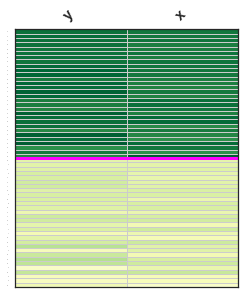

In [27]:
%mml .render_crosscat --height=5 --width=4 s2 0

#### Confirm that the joint histograms match.

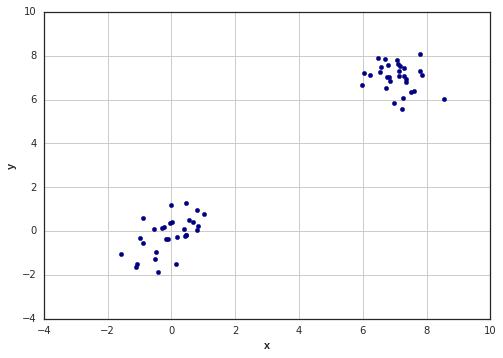

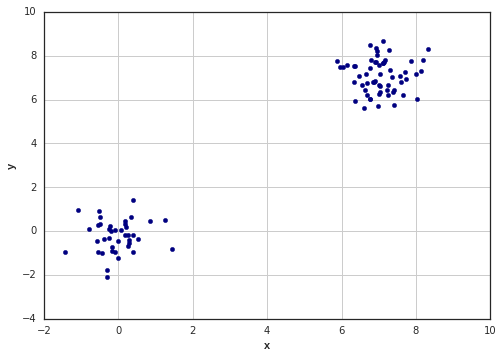

In [28]:
%bql .scatter SELECT x,y FROM t;
%bql .scatter SIMULATE x,y FROM p MODELED BY s2 LIMIT 100;